# ECE 570 Assignment 6 Exercise






Your Name: Jiayu Chen

## Exercise 1: Creating an image denoiser using a CNN autoencoder. (30 points)
In this exercise you are trying to build a autoencoder with CNN layers that can denoise images. 

### Task 1: Create additive noise transform
1. Add code to `AddGaussianNoise` transform class that will:
  * Add additive Gaussian noise to the batch of input images (i.e add noise with gaussian distribution on each pixel). The noise for every pixel should have mean value 0 and standard deviation of 0.3, i.e $ \epsilon \sim N(0, 0.3)$.
  * Clip the values to be between 0 and 1 again as they may be outside the range for pixel values after adding Gaussian noise.
2. Plot the first 3 training images and their noisy counterparts in a 2x3 subplot with appropriate titles, figure size, label, etc.

In this task, we concatenate the original dataset and noisy dataset and get a single dataloader. You should be careful with what you load at each iteration. In a more general case, there are many ways of dealing with multiple datasets. For example, you can create separate dataloaders and use ``zip`` to load samples from them. Here is a post discussing how to use ``zip`` [https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1](https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/1). 

In [ ]:
# Import and load MNIST data
import torchvision
import torch
import matplotlib.pyplot as plt


class AddGaussianNoise(object):
  ###########################   <YOUR CODE>  ############################
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    tensor += torch.randn(tensor.size()) * self.std + self.mean
    tensor[tensor<0] = 0.0
    tensor[tensor>1] = 1.0
    # print(tensor.size())
    return tensor



  #########################  <END YOUR CODE>  ############################


transform_noisy = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), AddGaussianNoise(0.,0.3)])
transform_original = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_noisy = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_noisy)
train_dataset_original = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform_original)
test_dataset_noisy = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_noisy)
test_dataset_original = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform_original)

print(torch.max(train_dataset_noisy.__getitem__(0)[0]).item())
print(torch.min(train_dataset_noisy.__getitem__(0)[0]).item())

1.0
0.0


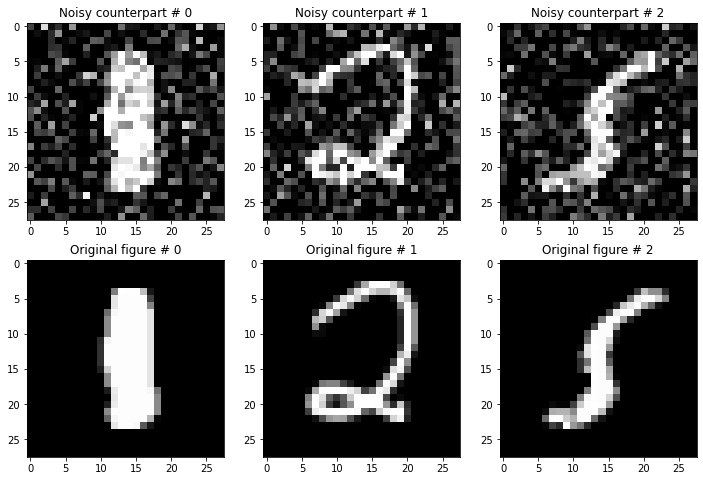

In [ ]:
class ConcatDataset(torch.utils.data.Dataset):
  def __init__(self, *datasets):
    self.datasets = datasets

  def __getitem__(self, i):
    return tuple(d[i][0] for d in self.datasets)

  def __len__(self):
    return min(len(d) for d in self.datasets)


batch_size_train, batch_size_test = 64, 1000
train_loader = torch.utils.data.DataLoader(ConcatDataset(train_dataset_noisy, train_dataset_original),
                      batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(ConcatDataset(test_dataset_noisy, test_dataset_original),
                      batch_size=batch_size_test, shuffle=False)

###########################   <YOUR CODE>  ############################
# Plot the first 3 training images with corresponding noisy images 
_, (noised, original) = next(enumerate(train_loader))

fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,8)
for idx in range(3):
  # print(noised.shape)
  ax[0,idx].imshow(noised[idx][0], cmap='gray')
  ax[0,idx].set_title('Noisy counterpart # {}'.format(idx))
  ax[1,idx].imshow(original[idx][0], cmap='gray')
  ax[1,idx].set_title('Original figure # {}'.format(idx))
fig.show()

#########################  <END YOUR CODE>  ############################

### Task 2: Create and train a denoising autoencoder
1. Build an autoencoder neural network structure with encoders and decoders that is a little more complicated than in the instructions. You can also create the network to have convolutional or transpose convolutional layers. (You can follow the instructions code skeleton with a key difference of using convolutional layers).
2. Move your model to GPU so that you can train your model with GPU. (This step can be simultaneously implemented in the above step)
3. Train your denoising autoencoder model with appropriate optimizer and **MSE** loss function. The loss function should be computed between the output of the noisy images and the clean images, i.e., $L(x, g(f(\tilde{x})))$, where $\tilde{x} = x + \epsilon$ is the noisy image and $\epsilon$ is the Gaussian niose. You should train your model with enough epochs so that your loss reaches a relatively steady value. **Note: Your loss on the test data should be lower than 20.** You may have to experiment with various model architectures to achieve this test loss.
4. Visualize your result with a 3 x 3 grid of subplots. You should show 3 test images, 3 test images with noise added, and 3 test images reconstructed after passing your noisy test images through the DAE.

We are using device name "cuda"
Epoch 1: [0/60000] Loss: 144.69821166992188
Epoch 1: [6400/60000] Loss: 142.63966369628906
Epoch 1: [12800/60000] Loss: 140.34735107421875
Epoch 1: [19200/60000] Loss: 136.94253540039062
Epoch 1: [25600/60000] Loss: 134.7090606689453
Epoch 1: [32000/60000] Loss: 131.91709899902344
Epoch 1: [38400/60000] Loss: 127.17936706542969
Epoch 1: [44800/60000] Loss: 121.81492614746094
Epoch 1: [51200/60000] Loss: 115.57545471191406
Epoch 1: [57600/60000] Loss: 107.71637725830078
Test result on epoch 1: Avg loss is 105.34084765625
Epoch 2: [0/60000] Loss: 105.24542236328125
Epoch 2: [6400/60000] Loss: 95.93466186523438
Epoch 2: [12800/60000] Loss: 86.654052734375
Epoch 2: [19200/60000] Loss: 76.46189880371094
Epoch 2: [25600/60000] Loss: 69.79054260253906
Epoch 2: [32000/60000] Loss: 60.42207336425781
Epoch 2: [38400/60000] Loss: 54.463226318359375
Epoch 2: [44800/60000] Loss: 51.31240463256836
Epoch 2: [51200/60000] Loss: 44.665618896484375
Epoch 2: [57600/60000] 

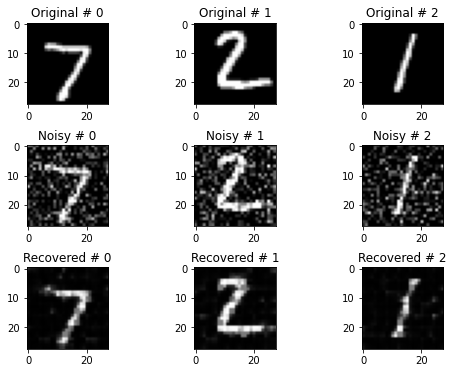

In [ ]:
###########################   <YOUR CODE>  ############################
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class our_AE(nn.Module):
  def __init__(self):
    super(our_AE, self).__init__()

    # encoder
    self.en_conv1 = nn.Conv2d(1, 5, kernel_size=2, stride=2)
    self.en_conv2 = nn.Conv2d(5, 8, kernel_size=2, stride=2)

    # decoder
    self.de_conv1 = nn.ConvTranspose2d(8, 5, kernel_size=2, stride=2)
    self.de_conv2 = nn.ConvTranspose2d(5, 1, kernel_size=2, stride=2)

  def forward(self, x):

    # encoding layers
    x = F.relu(self.en_conv1(x))
    x = F.relu(self.en_conv2(x))

    # decoding layers
    x = F.relu(self.de_conv1(x))
    x = torch.sigmoid(self.de_conv2(x))
    return x

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

AE = our_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)
loss_fn = nn.MSELoss(reduction='sum')

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (noised, original) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = noised.to(device)
    labels = original.to(device)
    output = AE(images)
    loss = loss_fn(output, labels) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')


def test(epoch, device):

  AE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for _, (noised, original) in enumerate(test_loader):
      images = noised.to(device)
      labels = original.to(device)
      output = AE(images)
      test_loss += loss_fn(output, labels).item()
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')


train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  test(epoch, device=device)

_, (noised, original) = next(enumerate(test_loader))
images = noised.to(device)
output = AE(images).cpu().detach()
noised = images.cpu()

fig,ax = plt.subplots(3,3)
fig.set_size_inches(12,6)
plt.subplots_adjust(wspace=-0.5, hspace=0.5)

for idx in range(3):
  ax[0,idx].imshow(original[idx][0], cmap='gray')
  ax[0,idx].set_title('Original # {}'.format(idx))
  ax[1,idx].imshow(noised[idx][0], cmap='gray')
  ax[1,idx].set_title('Noisy # {}'.format(idx))
  ax[2,idx].imshow(output[idx][0], cmap='gray')
  ax[2,idx].set_title('Recovered # {}'.format(idx))

#########################  <END YOUR CODE>  ############################

## Exercise 2: Build a variational autoencoder(VAE) that can generate MNIST images (70 points)

### Task 0: Setup
1. Import necessary packages
2. Load the MNIST data as above.
3. Specify the device.

In [23]:
###########################   <YOUR CODE>  ############################
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Images already in [0,1]

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

device = 'cuda' if torch.cuda.is_available()==True else 'cpu'
# device = 'cpu'
device = torch.device(device)
print(f'We are using device name "{device}"')

#########################  <END YOUR CODE>  ############################

We are using device name "cuda"


### Task 1: VAE Loss function
Construct your loss function. The loss function for VAE is a little bit difficult:
$$
\begin{aligned}
\textbf{NegativeELBO}(x, g, f) &= \mathbb{E}_{q_f}[-\log p_g(x|z)] + KL(q_f(z|x), p_g(z))\\
 &= \text{ReconstructionLoss} + \text{Regularizer}
\end{aligned}
$$
In this exercise, you will build the VAE (variational autoencoder) model satisfying following conditions which simplifies the computation of loss function:
1. $p_g(z)$ is a standard normal distribution.
2. $q_f(z|x)$ is a multivariate Gaussian with trainable mean and variance along each dimension.
3. The output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.

While we discussed the Gaussian distribution in class, here we assume the output distribution of the decoder is an independent Bernoulli distribution for every pixel value since the values are between 0 and 1.
The value of the pixel corresponds to the average of the Bernoulli distribution.
This loss can be seen in Appendix C.1 of the original VAE paper: https://arxiv.org/pdf/1312.6114.pdf.
With such assumpition, the reconstruction loss can be calculated using the binary-cross-entropy loss between the original images and the output of the VAE.
See [torch.nn.functional.binary_cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#binary-cross-entropy).
You should use the sum reduction of the loss to sum the loss over all the pixels. 

The second part is the KL-Divergence between your model's approximate posterier $q_f(z|x)$ and the model prior $p_g(z)$.
If we assume $p_g(z)$ is a standard normal distribution and $q_f(z|x)$ is a Gaussian with unknown mean and variance, then this KL divergence can be computed in closed form (see Appendix B of original VAE paper above):
$KL(q_f(z|x), p_g(z)) = -\frac{1}{2}\sum_{j=1}^d(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2)$. 


Your task here is to write a function `vae_loss` that takes the value of your model's output, the original images, mu, and log_var (i.e., the $\log(\sigma_j^2)$ term), and returns the the reconstruction loss and the KL loss terms **separately** (i.e., the function should return two loss arrays). To visualize these losses separately in a later task, you will need the reconstruction loss and KL loss separated.


In [30]:
def vae_loss(output, mu, log_var, images):
  """
  :param output: this the output of your neural network
  :param mu: this is the mu from the latent space
  :param log_var: this is the log_var from the latent space
  :param images: this is the original sets of images
  """
  ###########################   <YOUR CODE>  ############################
  bce_loss = nn.functional.binary_cross_entropy(output, images, reduction='sum')
  kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return bce_loss + kl_loss, bce_loss, kl_loss
  #########################  <END YOUR CODE>  ############################


### Task 2: VAE model
Build the VAE (variational autoencoder) model based on the instructions given below and in the comments.
* Inside the `reparameterize` function you job is to output a latent vector. You should first calculate the standard deviation `std` from the log variance variable `log_var` (i.e., compute $\sigma$ from $\log (\sigma^2)$, then generate the vector in Gaussian distribution with `mu` and `std`.  **Importantly**, this should use the reparametrization trick so that we can backpropagate through this random step.

* Inside the `forward` function you should extract the `mu` and `log_var` from the latent representation after the encoder. The output of encoder should be in the dimension ` [batch_size x 2 x latent_feature]`, which includes a mean and log variance for each latent feature and for each instance in the batch.  Remember that in VAEs, the encoder outputs the parameters of the latent distribution. Note that the second dimension has value 2, so you need to split this tensor into two components, one called `mu` and the other called `log_var`---which will be fed into reparameterize.



In [25]:

class our_VAE(nn.Module):
  def __init__(self, latent_feature = 16): # you can use any number of latent features you want in the training
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    ###########################   <YOUR CODE>  ############################
    # define the transformations for your encoder and decoder
    self.enc1 = nn.Linear(in_features=784, out_features=512)
    self.enc2 = nn.Linear(in_features=512, out_features=self.latent_feature*2)

    self.dec1 = nn.Linear(in_features=self.latent_feature, out_features=512)
    self.dec2 = nn.Linear(in_features=512, out_features=784)

    #########################  <END YOUR CODE>  ############################

  def reparameterize(self, mu, log_var):
    """
    :param mu: mean from the latent space
    :param log_var: the log variance from the latent space

    You should return a sample with gaussian distribution N(mu, var) using 
    the reparameterization trick.
    """
    ###########################   <YOUR CODE>  ############################
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    sample = mu + (eps * std)

    #########################  <END YOUR CODE>  ############################
    return sample
  def encoder(self, x):
    """
    :param x: input distribution

    You should first compute the parameters mu and log_var for Gaussian distribution q(z|x), and 
    then get samples from q(z|x) using the reparameterize function you just created.
    The final output should include mu, log_var and z~q(z|x)
    """
    ###########################   <YOUR CODE>  ############################
    x = x.view(-1, 784)
    x = F.relu(self.enc1(x))
    x = self.enc2(x).view(-1, 2, self.latent_feature)

    mu = x[:, 0, :] 
    log_var = x[:, 1, :]

    z = self.reparameterize(mu, log_var)
    #########################  <END YOUR CODE>  ###########################

    return mu, log_var, z

  def decoder(self, z):
    """
    :param z: latent distribution

    You should compute the output x given latent samples z
    """

    ###########################   <YOUR CODE>  ############################
    x = F.relu(self.dec1(z))
    x = torch.sigmoid(self.dec2(x))
    x = x.view(-1, 1, 28, 28)
    #########################  <END YOUR CODE>  ###########################
    return x


  
  def forward(self, x):
    """
    :param x: input variables

    You should compute the output images using the encoder and decoder you just defined.
    Remember to return the mu and log_var for the computation of loss.
    """

    ###########################   <YOUR CODE>  ############################
    mu, log_var, z = self.encoder(x)
    x = self.decoder(z)
    #########################  <END YOUR CODE>  ###########################

    
    return x, mu, log_var

### Task 3: Train and visualize output
1. Train your model with an appropriate optimizer and the above loss function. You should train your model with enough epochs so that your loss reaches a relatively steady value.

2. Visualize your result. You should **show three pairs of images** where each pair consists of an original test image and its VAE reconstructed version.

3. Keep track of the loss. You should save the negative ELBO, Reconstruction Loss and KL Divergence Loss after every 10 batches in the trainining and **create a plot with three curves** using [matplotlib.pyplot.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Each curve should correpond to one of the losses. The x-axis will be the number of batches divided by 10 and the y-axis will be the loss. **Make sure you clearly specify the legend, x-label and y-label.**

**Note:** It is always a good idea to keep track of the loss in the process of training to help you understand what is happening during training.

Epoch 1: [0/60000] Loss: 549.5863037109375
Epoch 1: [6400/60000] Loss: 267.61578369140625
Epoch 1: [12800/60000] Loss: 224.65269470214844
Epoch 1: [19200/60000] Loss: 219.6649169921875
Epoch 1: [25600/60000] Loss: 203.91195678710938
Epoch 1: [32000/60000] Loss: 194.13401794433594
Epoch 1: [38400/60000] Loss: 188.26011657714844
Epoch 1: [44800/60000] Loss: 185.9822235107422
Epoch 1: [51200/60000] Loss: 171.8433380126953
Epoch 1: [57600/60000] Loss: 169.3655548095703
Epoch 2: [0/60000] Loss: 161.647216796875
Epoch 2: [6400/60000] Loss: 155.2527618408203
Epoch 2: [12800/60000] Loss: 153.6131134033203
Epoch 2: [19200/60000] Loss: 151.61692810058594
Epoch 2: [25600/60000] Loss: 146.447265625
Epoch 2: [32000/60000] Loss: 144.22482299804688
Epoch 2: [38400/60000] Loss: 144.34254455566406
Epoch 2: [44800/60000] Loss: 142.7903289794922
Epoch 2: [51200/60000] Loss: 142.1188201904297
Epoch 2: [57600/60000] Loss: 142.84396362304688
Epoch 3: [0/60000] Loss: 145.52557373046875
Epoch 3: [6400/60000] 

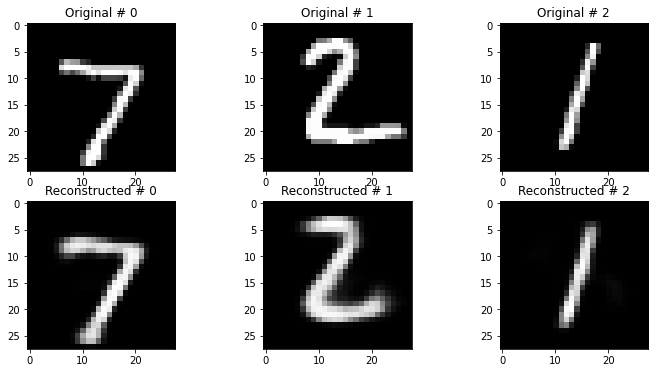

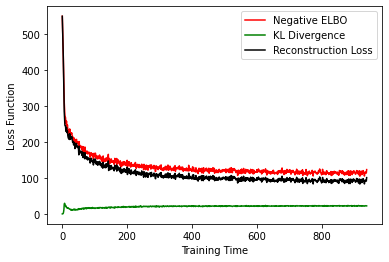

In [34]:
###########################   <YOUR CODE>  ############################
import matplotlib.pyplot as plt

AE = our_VAE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)

train_losses = []
train_kl_losses = []
train_bce_losses = []
train_counter = []
max_epoch = 10

def train(epoch, device):

  AE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels

    optimizer.zero_grad()
    images = images.to(device)
    output, mu, log_var = AE(images)
    loss, bce_loss, kl_loss = vae_loss(output, mu, log_var, images) # Here is a typical loss function (Mean square error)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_kl_losses.append(kl_loss.item()/batch_size_train)
      train_bce_losses.append(bce_loss.item()/batch_size_train)
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)


batch_idx, (images, _) = next(enumerate(test_loader))
images = images.to(device)
output, _, _ = AE(images)
output = output.cpu().detach()
images = images.cpu()

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

for idx in range(3):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[0,idx].set_title('Original # {}'.format(idx))
  ax[1,idx].imshow(output[idx][0], cmap='gray')
  ax[1,idx].set_title('Reconstructed # {}'.format(idx))

fig.show()


fig_, ax_ = plt.subplots()
tot_len = len(train_losses)
x = list(range(tot_len))
ax_.plot(x, train_losses, color = 'r', label="Negative ELBO")
ax_.plot(x, train_kl_losses, color = 'g', label="KL Divergence")
ax_.plot(x, train_bce_losses, color = 'black', label="Reconstruction Loss")
ax_.set_xlabel("Training Time")
ax_.set_ylabel("Loss Function")
ax_.legend(loc = "best")
fig_.show()


#########################  <END YOUR CODE>  ###########################


### Task 4.1: Latent space of VAE

The latent space will change over time during training as the networks learn which features of the input are most important.  In the beginning, the reconstruction error will be poor and the latent space will be mixed up (i.e., it has not identified good features for dimensionality reduction and then reconstruction).  However, as it continues to train, the space will begin to show some structure (similar to in PCA) as it finds features that enable good reconstruction even after adding a little noise. Therefore, to get some intuition about this process, in this task, you will visualize how latent space changes in the process of training with the given function ``plot_latent``.

1. For better visualization, create a VAE with ``latent_features=2``.
2. Similar to task 3, train the VAE for a few epochs. But you will need to plot the latent distribution using the provided ``plot_latent`` function below at initialization (so you can see what the latent space looks like at initialization) AND after **each** epoch. You should use the **test** data for plotting this visualization task.


In [36]:
def plot_latent(vae, data_loader, num_batches=2):
  with torch.no_grad():
    for ibx, (images,label) in enumerate(data_loader):
      
      _,_,z = vae.encoder(images)
      z = z.to('cpu').detach().numpy()
      plt.scatter(z[:, 0], z[:, 1], c=label, cmap='tab10',s=1)
      if ibx > num_batches:
        break
  plt.colorbar()
  plt.show()

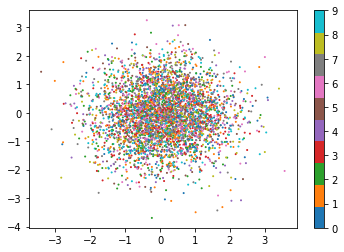

Epoch 1: [0/60000] Loss: 550.101806640625
Epoch 1: [6400/60000] Loss: 254.81448364257812
Epoch 1: [12800/60000] Loss: 222.39234924316406
Epoch 1: [19200/60000] Loss: 217.12603759765625
Epoch 1: [25600/60000] Loss: 221.0151824951172
Epoch 1: [32000/60000] Loss: 201.03944396972656
Epoch 1: [38400/60000] Loss: 202.3955535888672
Epoch 1: [44800/60000] Loss: 205.36802673339844
Epoch 1: [51200/60000] Loss: 195.1101531982422
Epoch 1: [57600/60000] Loss: 181.9686279296875


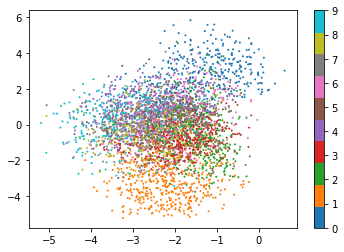

Epoch 2: [0/60000] Loss: 189.36990356445312
Epoch 2: [6400/60000] Loss: 194.05575561523438
Epoch 2: [12800/60000] Loss: 179.4716796875
Epoch 2: [19200/60000] Loss: 183.0606231689453
Epoch 2: [25600/60000] Loss: 183.08172607421875
Epoch 2: [32000/60000] Loss: 181.91748046875
Epoch 2: [38400/60000] Loss: 189.5663604736328
Epoch 2: [44800/60000] Loss: 185.24366760253906
Epoch 2: [51200/60000] Loss: 178.2762908935547
Epoch 2: [57600/60000] Loss: 182.92367553710938


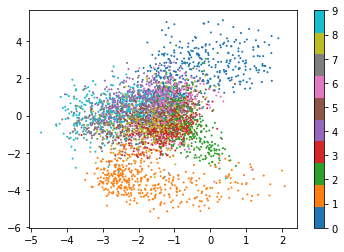

Epoch 3: [0/60000] Loss: 181.1171875
Epoch 3: [6400/60000] Loss: 166.98715209960938
Epoch 3: [12800/60000] Loss: 171.95504760742188
Epoch 3: [19200/60000] Loss: 178.48306274414062
Epoch 3: [25600/60000] Loss: 170.146240234375
Epoch 3: [32000/60000] Loss: 171.4625701904297
Epoch 3: [38400/60000] Loss: 177.55953979492188
Epoch 3: [44800/60000] Loss: 180.08168029785156
Epoch 3: [51200/60000] Loss: 183.56600952148438
Epoch 3: [57600/60000] Loss: 182.58096313476562


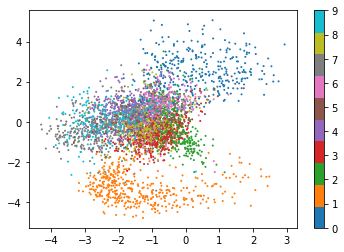

Epoch 4: [0/60000] Loss: 169.30328369140625
Epoch 4: [6400/60000] Loss: 166.62680053710938
Epoch 4: [12800/60000] Loss: 168.78543090820312
Epoch 4: [19200/60000] Loss: 173.32716369628906
Epoch 4: [25600/60000] Loss: 173.0457305908203
Epoch 4: [32000/60000] Loss: 160.06898498535156
Epoch 4: [38400/60000] Loss: 171.06272888183594
Epoch 4: [44800/60000] Loss: 176.48583984375
Epoch 4: [51200/60000] Loss: 165.72177124023438
Epoch 4: [57600/60000] Loss: 181.21951293945312


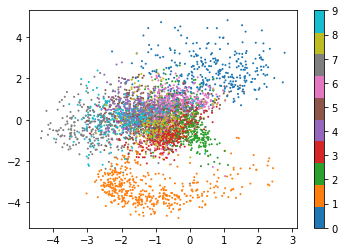

Epoch 5: [0/60000] Loss: 168.41299438476562
Epoch 5: [6400/60000] Loss: 169.15658569335938
Epoch 5: [12800/60000] Loss: 168.6422119140625
Epoch 5: [19200/60000] Loss: 168.5016326904297
Epoch 5: [25600/60000] Loss: 170.1812286376953
Epoch 5: [32000/60000] Loss: 163.80870056152344
Epoch 5: [38400/60000] Loss: 172.06324768066406
Epoch 5: [44800/60000] Loss: 162.8452911376953
Epoch 5: [51200/60000] Loss: 165.61752319335938
Epoch 5: [57600/60000] Loss: 163.2535858154297


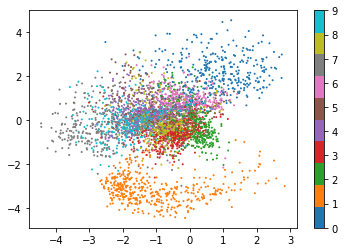

Epoch 6: [0/60000] Loss: 167.5115966796875
Epoch 6: [6400/60000] Loss: 168.78250122070312
Epoch 6: [12800/60000] Loss: 164.56190490722656
Epoch 6: [19200/60000] Loss: 155.13755798339844
Epoch 6: [25600/60000] Loss: 160.1558380126953
Epoch 6: [32000/60000] Loss: 175.49766540527344
Epoch 6: [38400/60000] Loss: 163.94593811035156
Epoch 6: [44800/60000] Loss: 173.11570739746094
Epoch 6: [51200/60000] Loss: 168.4073028564453
Epoch 6: [57600/60000] Loss: 174.3579559326172


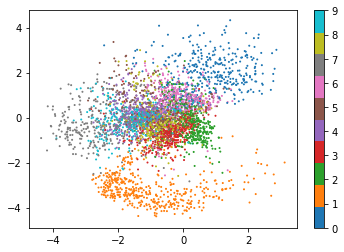

Epoch 7: [0/60000] Loss: 171.10690307617188
Epoch 7: [6400/60000] Loss: 161.57489013671875
Epoch 7: [12800/60000] Loss: 169.57571411132812
Epoch 7: [19200/60000] Loss: 165.2769012451172
Epoch 7: [25600/60000] Loss: 166.2859649658203
Epoch 7: [32000/60000] Loss: 164.9591064453125
Epoch 7: [38400/60000] Loss: 175.2254638671875
Epoch 7: [44800/60000] Loss: 168.29632568359375
Epoch 7: [51200/60000] Loss: 170.6071319580078
Epoch 7: [57600/60000] Loss: 174.16990661621094


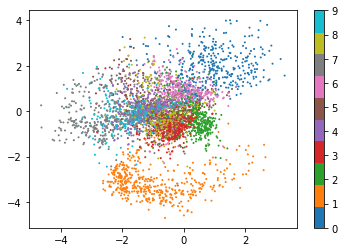

Epoch 8: [0/60000] Loss: 164.66592407226562
Epoch 8: [6400/60000] Loss: 162.9079132080078
Epoch 8: [12800/60000] Loss: 167.9219512939453
Epoch 8: [19200/60000] Loss: 165.94876098632812
Epoch 8: [25600/60000] Loss: 151.46218872070312
Epoch 8: [32000/60000] Loss: 164.39047241210938
Epoch 8: [38400/60000] Loss: 167.40895080566406
Epoch 8: [44800/60000] Loss: 159.13902282714844
Epoch 8: [51200/60000] Loss: 152.73703002929688
Epoch 8: [57600/60000] Loss: 172.21133422851562


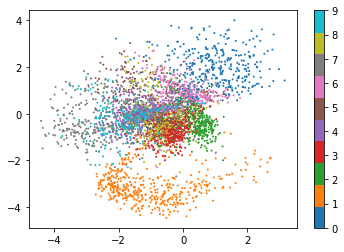

Epoch 9: [0/60000] Loss: 165.23159790039062
Epoch 9: [6400/60000] Loss: 168.926025390625
Epoch 9: [12800/60000] Loss: 152.58685302734375
Epoch 9: [19200/60000] Loss: 161.18861389160156
Epoch 9: [25600/60000] Loss: 156.5690460205078
Epoch 9: [32000/60000] Loss: 163.2412109375
Epoch 9: [38400/60000] Loss: 162.75753784179688
Epoch 9: [44800/60000] Loss: 162.5472869873047
Epoch 9: [51200/60000] Loss: 162.37171936035156
Epoch 9: [57600/60000] Loss: 166.801025390625


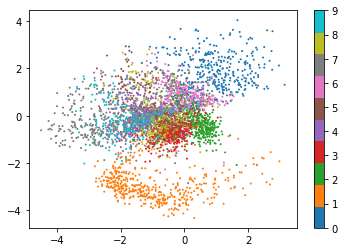

Epoch 10: [0/60000] Loss: 162.1105499267578
Epoch 10: [6400/60000] Loss: 171.96652221679688
Epoch 10: [12800/60000] Loss: 160.38941955566406
Epoch 10: [19200/60000] Loss: 160.3501739501953
Epoch 10: [25600/60000] Loss: 163.14474487304688
Epoch 10: [32000/60000] Loss: 157.4066925048828
Epoch 10: [38400/60000] Loss: 161.0712432861328
Epoch 10: [44800/60000] Loss: 159.94068908691406
Epoch 10: [51200/60000] Loss: 166.844970703125
Epoch 10: [57600/60000] Loss: 162.07748413085938


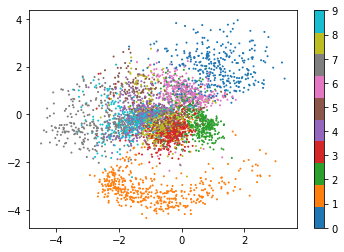

In [40]:
###########################   <YOUR CODE>  ############################
AE = our_VAE(2).to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)

train_losses = []
train_kl_losses = []
train_bce_losses = []
train_counter = []
max_epoch = 10

plot_latent(AE.to('cpu'), test_loader)
for epoch in range(1, max_epoch+1):
  AE.to(device)
  train(epoch, device=device)
  plot_latent(AE.to('cpu'), test_loader)

#########################  <END YOUR CODE>  ###########################

### Task 4.2 Interpolation of latent space

Interpolation can be quite useful for autoencoder models. For example, by linearly interpolating (or mixing) codes in latent space and decoding the result, the autoencoder can produce a more **semantically meaningful**
combination of the corresponding datapoints than linear interpolation in the raw pixel space. 
Besides, in some cases, interpolation experiments can show that the model has learned a latent space with a particular structure. Specifically, if interpolation between points in the latent space shows a smooth semantic warping in the original image space, then the visualization may suggest that similar points are semantically clustered in the latent space.

In this task, you will do a simple experiment to see the difference between linear interpolation in the latent space and the original data space (raw pixels).
1. With a trained model and test data, sample one $z\sim q(z|x)$ corresponding to label 0 and 1 separately (two samples in total); this can be done by passing test samples (with labels 0 and 1 respectively) through the encoder. These two latent samples will be denoted $z_0$ and $z_1$ respectively.

2. Compute the linear interpolation of $x_0$ and $x_1$ in the following way: $x'=\alpha x_1 + (1-\alpha)x_0$ where $\alpha = 0, 0.1, 0.2, \dots, 0.9, 1.0$. **Plot** all $x'$ images you get in a 1x11 grid.

3. Compute the latent linear interpolation of $z_0$ and $z_1$ to get $z'$ in a similar way. Then, reconstruct the $x'$ corresponding to each $z'$ using the decoder. **Plot** all $x'$ images you get in a 1x11 grid.

Epoch 1: [0/60000] Loss: 549.58251953125
Epoch 1: [6400/60000] Loss: 263.5586853027344
Epoch 1: [12800/60000] Loss: 229.77044677734375
Epoch 1: [19200/60000] Loss: 213.72889709472656
Epoch 1: [25600/60000] Loss: 198.47447204589844
Epoch 1: [32000/60000] Loss: 198.04806518554688
Epoch 1: [38400/60000] Loss: 171.4009552001953
Epoch 1: [44800/60000] Loss: 165.09353637695312
Epoch 1: [51200/60000] Loss: 164.8079833984375
Epoch 1: [57600/60000] Loss: 169.35086059570312
Epoch 2: [0/60000] Loss: 167.10968017578125
Epoch 2: [6400/60000] Loss: 161.4509735107422
Epoch 2: [12800/60000] Loss: 169.68609619140625
Epoch 2: [19200/60000] Loss: 161.3544921875
Epoch 2: [25600/60000] Loss: 157.84054565429688
Epoch 2: [32000/60000] Loss: 149.0515899658203
Epoch 2: [38400/60000] Loss: 149.57858276367188
Epoch 2: [44800/60000] Loss: 146.34622192382812
Epoch 2: [51200/60000] Loss: 146.18626403808594
Epoch 2: [57600/60000] Loss: 143.69154357910156
Epoch 3: [0/60000] Loss: 137.9442138671875
Epoch 3: [6400/6000

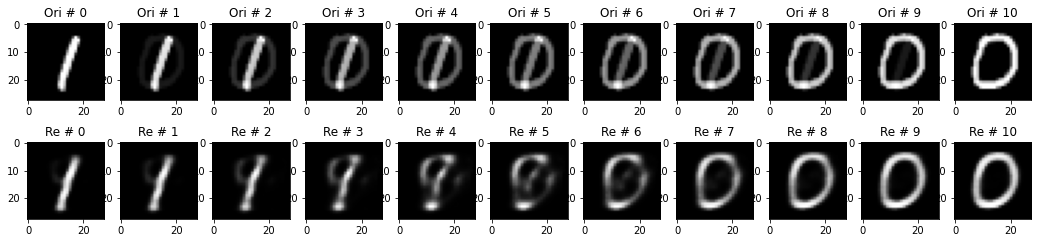

In [51]:
###########################   <YOUR CODE>  ############################
import numpy as np

AE = our_VAE().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-4)

train_losses = []
train_kl_losses = []
train_bce_losses = []
train_counter = []
max_epoch = 10

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)

batch_idx, (images, labels) = next(enumerate(test_loader))
x_1 = images[labels == 1][1]
x_0 = images[labels == 0][1]
# print(x_1.shape)
original_list = [(x_1 + (x_0 - x_1)*t).numpy() for t in np.linspace(0, 1, 11)]

_, _, z_1 = AE.encoder(x_1.to(device))
_, _, z_0 = AE.encoder(x_0.to(device))
z = torch.stack([z_1 + (z_0 - z_1)*t for t in np.linspace(0, 1, 11)])
interpolate_list = AE.decoder(z)
interpolate_list = interpolate_list.to('cpu').detach().numpy()


fig, ax = plt.subplots(2,11)
fig.set_size_inches(18,4)

for idx in range(11):
  ax[0,idx].imshow(original_list[idx][0], cmap='gray')
  ax[0,idx].set_title('Ori # {}'.format(idx))
  ax[1,idx].imshow(interpolate_list[idx][0], cmap='gray')
  ax[1,idx].set_title('Re # {}'.format(idx))

fig.show()


#########################  <END YOUR CODE>  ###########################